## **1. Import Package**

In [1]:
!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, classification_report
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
import re
from imblearn.combine import SMOTETomek
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from collections import Counter

## **2. Load Data**

Pada tahap ini dilakukan **load_data** menggunakan `pandas` untuk membaca `csv`. 

In [3]:
df = pd.read_csv('Hospital_Indonesia_datasets.csv', sep=';')
df.head()

,id,nama,propinsi,kab,alamat,jenis,kelas,status_blu,kepemilikan,total_tempat_tidur,total_layanan,total_tenaga_kerja
0,1110053,RS Arun Lhokseumawe,Aceh,Kota Lhokseumawe,Jl. Plaju Komplek Perumahan PT Arun Batuphat T...,Rumah Sakit Umum,C,Non BLU/BLUD,SWASTA/LAINNYA,218,36,328
1,1106014,RS Umum Fandika,Aceh,Aceh Tengah,Jl. Terminal Simpang Wariji Blangkolak 1 Kec. ...,Rumah Sakit Umum,D,Non BLU/BLUD,SWASTA/LAINNYA,45,15,45
2,1171110,RS Umum Daerah Meuraxa,Aceh,Kota Banda Aceh,Jl. Soekarno Hatta Km. 2 Desa Mibo Kecamatan B...,Rumah Sakit Umum,B,BLUD,Pemkot,310,77,487
3,1171163,RS Gigi Mulut Universitas Syiah Kuala,Aceh,Kota Banda Aceh,Jl. Prof A. Madjid Ibrahim I No. 5 Banda Aceh ...,Rumah Sakit Khusus Gigi dan Mulut,B,BLU,Kementerian Lain,11,24,0
4,1102027,RS Umum Daerah Kota Subulussalam,Aceh,Kota Subulussalam,Jl. Hamzah Fansyuri (Subulussalam-Rundeng) K...,Rumah Sakit Umum,C,BLUD,Pemkot,189,34,537


## **3. Data Understanding**

Pada tahap ini akan dilakukan analisa awal pada data yang diberikan untuk memahami karakteristik dan struktur data. Analisis ini penting sebagai dasar dalam menentukan strategi preprocessing data selanjutnya serta pemilihan algoritma yang sesuai untuk model machine learning.

Akan diperiksa ringkasan dari dataset tersebut menggunakan `describe(include='all')`. Parameter `include='all'` bermaksud menyertakan semua deskripsi data. 

In [4]:
df.describe(include='all')

,id,nama,propinsi,kab,alamat,jenis,kelas,status_blu,kepemilikan,total_tempat_tidur,total_layanan,total_tenaga_kerja
count,3.155000e+03,3155,3155,3155,3155,3155,3155,3155,3155,3155.000000,3155.000000,3155.000000
unique,NaN,3091,38,511,3155,21,8,7,22,NaN,NaN,NaN
top,NaN,RS Ibu dan Anak Annisa,Jawa Timur,Kota Surabaya,Jl. Plaju Komplek Perumahan PT Arun Batuphat T...,Rumah Sakit Umum,C,Non BLU/BLUD,SWASTA/LAINNYA,NaN,NaN,NaN
freq,NaN,4,432,64,1,2644,1710,2335,869,NaN,NaN,NaN
mean,3.803327e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.433914,41.097306,261.980666
std,2.005303e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.960235,30.583893,382.352731
min,1.101015e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000
25%,3.171859e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.000000,22.000000,56.500000
50%,3.325039e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.000000,31.000000,153.000000
75%,5.103046e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.000000,50.000000,335.000000


**Insight:** 

Ada masalah pada:
- kolom `total_tempat_tidur` yang bernilai 0 karena tidak mungkin, serta maksimal tempat tidurnya sebanyak 30343 yang cukup mustahil (menyebabkan outlier).
- kolom `total_tenaga_kerja` yang bernilai 0 karena tidak mungkin, serta maksimal total tenaga kerja sebanyak 7939 yang cukup mustahil (menyebabkan outlier).

Akan diperiksa jumlah total entri, rentang indeks, nama kolom , jumlah nilai non-null tiap kolom, dan tipe data tiap kolom menggunakan `info()`.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  3155 non-null   int64 
 1   nama                3155 non-null   object
 2   propinsi            3155 non-null   object
 3   kab                 3155 non-null   object
 4   alamat              3155 non-null   object
 5   jenis               3155 non-null   object
 6   kelas               3155 non-null   object
 7   status_blu          3155 non-null   object
 8   kepemilikan         3155 non-null   object
 9   total_tempat_tidur  3155 non-null   int64 
 10  total_layanan       3155 non-null   int64 
 11  total_tenaga_kerja  3155 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 295.9+ KB


Akan diperiksa apakah ada data yang kosong di tiap kolom menggunakan `isnull().sum()`, sedangkan untuk mengecek banyak data duplikat dengan `duplicated().sum()`.

In [6]:
df.isnull().sum()

id                    0
nama                  0
propinsi              0
kab                   0
alamat                0
jenis                 0
kelas                 0
status_blu            0
kepemilikan           0
total_tempat_tidur    0
total_layanan         0
total_tenaga_kerja    0
dtype: int64

In [7]:
print("banyak duplikat:", df.duplicated().sum())

banyak duplikat: 0


**Insight:** 

Tidak ada data duplikat dan kosong.

Pada bagian berikutnya akan dilakukan analisa beberapa kolom dan mengaitkannya dengan kolom lain. Hal ini dapat dilakukan dengan `groupby`.

In [8]:
# mengamati nilai dan ukurannya
df.groupby('kelas').size()

kelas
A                            77
B                           443
Belum Ditetapkan              3
C                          1710
D                           854
D PRATAMA                    64
Rumah Sakit Khusus Jiwa       1
Rumah Sakit Umum              3
dtype: int64

**Insight:**

 Terdapat masalah dalam kolom `kelas`:
- "Belum ditetapkan" akan dibuang.
- "Rumah sakit Khusus Jiwa" dan "Rumah Sakit Umum" seharusnya termasuk ke kolom `jenis`, bukan `kelas`. Maka data ini akan dibuang.
- "D PRATAMA" akan diubah ke "D".

Selanjutnya akan dihitung banyak propinsi yang ada dalam dataset dan ukurannya per nilai. 

In [9]:
# banyak propinsi
df['propinsi'].nunique()

38

In [10]:
# banyak rumah sakit per propinsi
df.groupby('propinsi').size().sort_values(ascending=False)

propinsi
Jawa Timur                   432
Jawa Barat                   421
Jawa Tengah                  355
Sumatera Utara               202
DKI Jakarta                  188
Banten                       129
Sulawesi Selatan             123
Sumatera Selatan              87
Riau                          81
Yogyakarta                    80
Lampung                       80
Bali                          79
Aceh                          79
Sumatera Barat                78
Nusa Tenggara Timur           62
Kalimantan Timur              58
Kalimantan Barat              58
Sulawesi Utara                58
Kalimantan Selatan            50
Nusa Tenggara Barat           46
Jambi                         42
Sulawesi Tengah               39
Sulawesi Tenggara             38
Kepulauan Riau                35
Kalimantan Tengah             32
Kepulauan Bangka Belitung     28
Maluku                        28
Bengkulu                      26
Maluku Utara                  22
Gorontalo                     19
P

**Insight:**

Ada sebanyak 38 propinsi dalam dataset di mana rumah sakit terbanyak dan tersedikit berturut-turut dari propinsi Jawa Timur dan Papua Pegunungan. Selain itu, karena sangat beragamnya propinsi akan dilakukan pengelompokan dan menjadi fitur `bagian` (seperti Jawa, Suamtera, Kalimantan, dan Indonesia Timur) untuk kebutuhan melatih model nantinya.

Selanjutnya akan dilakukan analisis jenis rumah sakit dengan total tempat tidur yang dimiliki.

In [11]:
# jenis dengan kapasitas tempat tidur
df.groupby('jenis')['total_tempat_tidur'].count()

jenis
                                        1
-                                       1
021-26071997                            1
2                                       1
RS Kapal/Bergerak                       1
Rumah Sakit Ketergantungan Obat         1
Rumah Sakit Khusus Bedah               28
Rumah Sakit Khusus Gigi dan Mulut      34
Rumah Sakit Khusus Ginjal               2
Rumah Sakit Khusus Ibu dan Anak       322
Rumah Sakit Khusus Infeksi              2
Rumah Sakit Khusus Jantung             12
Rumah Sakit Khusus Jiwa                41
Rumah Sakit Khusus Kanker               4
Rumah Sakit Khusus Mata                38
Rumah Sakit Khusus Orthopedi            7
Rumah Sakit Khusus Otak                 1
Rumah Sakit Khusus Paru                 9
Rumah Sakit Khusus Stroke               1
Rumah Sakit Khusus THT-KL               4
Rumah Sakit Umum                     2644
Name: total_tempat_tidur, dtype: int64

**Insight:**

Terdapat masalah dalam kolom jenis:
- Terdapat `''` yang menjadi antisipasi untuk kolom lainnya karena tidak terdeteksi `pandas`. Akan dilakukan pada tahap preprocessing.
- Terdapat "021-26071997" dan "2" yang tidak sesuai sehingga perlu dibuang.
- "Rumah sakit umum" dengan rumah sakit khusus memiliki ketimpangan karena ditinjau per jenis. Maka "Rumah Sakit Khusus (+tipe detail)" akan dirubah ke "Rumah Sakit Khusus".
- "RS Kapal/Bergerak" akan dibuang.

Selanjutnya akan dinalisa rata-rata terhadap jumlah tempat tidur, layanan, dan tenaga kerja berdasarkan kategori `kelas` rumah sakit. Ini bertujuan memberikan gambaran umum mengenai kapasitas dan cakupan layanan masing-masing kelas rumah sakit.

In [12]:
df.groupby('kelas')[['total_tempat_tidur', 'total_layanan', 'total_tenaga_kerja']].mean()

,total_tempat_tidur,total_layanan,total_tenaga_kerja
kelas,,,
A,442.298701,78.467532,1360.064935
B,244.124153,77.103837,612.476298
Belum Ditetapkan,14.666667,14.333333,0.000000
C,112.745614,38.667836,219.478363
D,64.782201,25.680328,86.281030
D PRATAMA,32.843750,12.828125,20.421875
Rumah Sakit Khusus Jiwa,1296.000000,27.000000,13.000000
Rumah Sakit Umum,11176.333333,173.000000,61.666667


**Insight:**

- Rumah sakit kelas A memiliki rata-rata tertinggi dari segi total tempat tidur, total layanan, dan total tenaga kerja. Ini menunjukkan kelas ini merupakan kapasitas pelayanan tertinggi dibanding kelas lainnya.

- Rumah sakit kelas B memiliki nilai rata-rata menengah, sedangkan kelas C dan D menunjukkan penurunan yang signifikan.

Selanjutnya akan dilakukan analisis total tempat tidur dan total tenaga kerja terhadap fitur `kepemilikan`.

In [13]:
df.groupby('kepemilikan')[['total_tempat_tidur', 'total_tenaga_kerja']].count()


,total_tempat_tidur,total_tenaga_kerja
kepemilikan,,
BLU,1,1
BLUD,1,1
BUMN,32,32
Kementerian Lain,39,39
Kemkes,38,38
Non BLU/BLUD,2,2
Organisasi Budha,1,1
Organisasi Hindu,2,2
Organisasi Islam,119,119


**Insight:**

Diperoleh:
- "BLU", "BLUD", dan "Non BLU/BLUD" harunya termasuk dalam `status_blu` sehingga perlu dibuang.
- Karena beragamnya jenis kepemilikan, akan dilakukan pengelompokan untuk kebutuhan pemodelan.
- "Pemkab", "Pemkot", "Pempro" diubah ke "Pemerintah Daerah"
- "Kemenkes", "POLRI", "TNI AD", "TNI AL", "TNI AU" diubah ke "Pemerintah Pusat"
- "Organisasi Keagamaan" untuk mengganti "Organisasi Islam", "Organisasi Katolik", dan lain-lain.
- "Perusahaan", "Perorangan", dan "SWASTA/LAINNYA" diubah ke "Swasta"

Selanjutnya akan dianalisa fitur numerik (`total_tempat_tidur`, `total_layanan`, dan `total_tenaga_kerja`) menggunakan boxplot dan KDEplot.

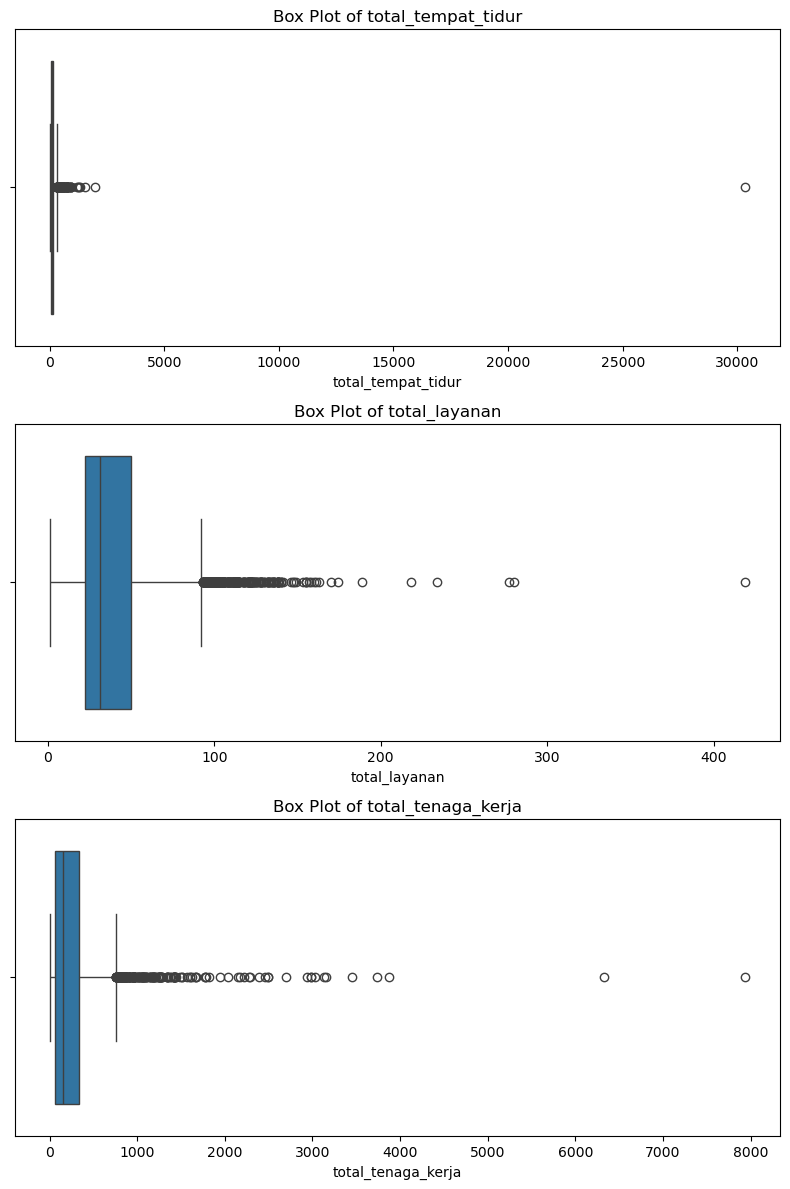

In [14]:
col_fig = 1
row_fig = 3
col_numeric = ['total_tempat_tidur', 'total_layanan', 'total_tenaga_kerja']

plt.figure(figsize=(8, 12))
for i, col in enumerate(col_numeric, 1):
    plt.subplot(row_fig,col_fig,i)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

**Insight:**

- Untuk `total_tempat_tidur` memiliki banyak outlier dengan satu outlier ekstrim karena ada data yang nilainya > 30.000.
- Untuk `total_layanan` sebagian besar rumah sakit memberikan layanan 0-100 jenis layanan, dengan outlier hingga lebih dari 400.
- Untuk `total_tenaga_kerja` juga mengandung outleir ekstrem (hingga hampir 8000 tenaga) kerja dan sebagian besar rumah sakit memiliki tenaga kerja kisaran < 1000.

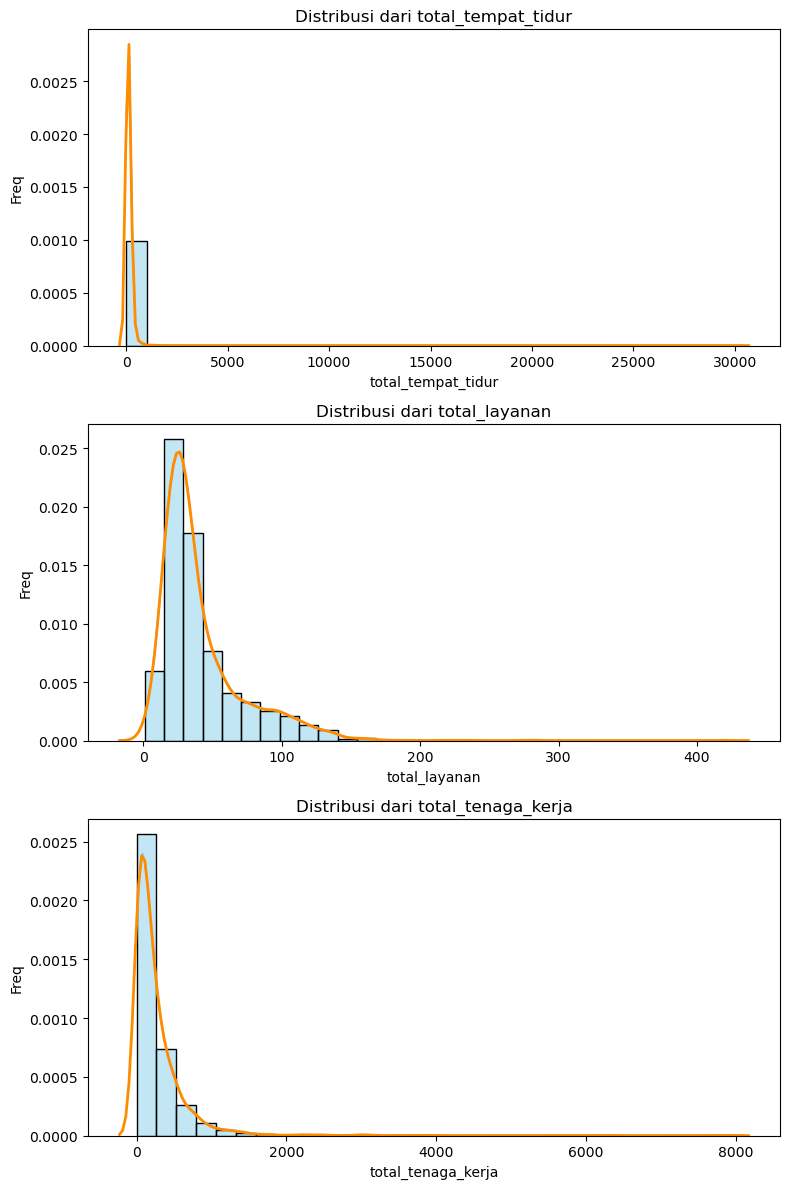

In [15]:
# melihat distribusi
plt.figure(figsize=(8, 12))
for i, col in enumerate(col_numeric, 1):
    plt.subplot(row_fig,col_fig,i)
    sns.histplot(df[col], kde=True, color='skyblue', bins=30, stat='density')
    sns.kdeplot(df[col], color='darkorange', linewidth=2)
    plt.xlabel(col)
    plt.ylabel('Freq')
    plt.title(f'Distribusi dari {col}')
plt.tight_layout()
plt.show()

**Insight:**

- Distribusi `total_tempat_tidur` sangat right-skewed. Sebagian besar rumah sakit memilki jumlah tempat tidur < 1000, namun terdapat outleir ekstrem hingga > 30000 tempat tidur. Perlu dipertimbangkan penanganan outlier dan transformasi (jika perlu) agar model tidak bias terhadap nilai ekstrem.
- Distribusi `total_layanan` juga right-skewed, menunjukkan sebagian besar rumah sakit umumnya memiliki layanan < 100. Sedikit rumah sakit yang menyediakan layanan dalam jumlah sangat besar (> 300) yang bisa jadi rumah sakit pusat atau berskala nasional.
- Distribusi `total_tenaga_kerja` sangat right-skewed. Sebagian besar rumah sakit memiliki tenaga kerja di bawah 1000 dengan outlier lebih mencapai lebih dari 7000 orang.

## **4. Data Preparation**

### **4.1. Menghapus data, kolom yang tidak relevan, dan mengganti beberapa kelompok nilai ke nilai yang lebih seragam dan informatif**

Pada tahap ini akan dilakukan proses pembersihan data untuk meningkatkan kualitas dan konsistensi dataset sebelum dilakukan analisis atau pemodelan.

**Mengganti ke nilai yang lebih seragam dan informatif**

Pada tahap ini akan dilakukan:
- Mengganti nilai-nilai yang tidak sesuai, seperti `''`, `' '`, atau sejenisnya ke `NaN`.
- Mengganti nilai-nilai yang tidak konsisten di kolom fitur ke `NaN`, seperti nilai "Rumah Sakit Umum" pada kolom `kelas` padahal seharusnya berada di kolom `jenis`.
- Mengganti nilai `0` ke `NaN` pada kolom `total_layanan` dan `total_tempat_tidur` karena tidak mungkin.
- Melakukan pengelompokan nilai kolom `propinsi` ke `bagian` dengan nilai-nilai Jawa, Sumatera, Kalimantan, dan Indonesia Timur.


In [16]:
# mengganti '', ' ' ke NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [17]:
df['kepemilikan'] = df['kepemilikan'].astype(str).str.strip()
df['kelas'] = df['kelas'].astype(str).str.strip()
df['jenis'] = df['jenis'].astype(str).str.strip()
df['propinsi'] = df['propinsi'].astype(str).str.strip()

In [18]:
# mengganti nilai yang tidak konsisten pada kolom jenis dan merubah ke NaN jika tidak konsisten
df['kelas'] = df['kelas'].replace({
    # variabel tidak valid
    'Belum Ditetapkan': np.nan,
    'Rumah Sakit Khusus Jiwa': np.nan, 
    'Rumah Sakit Umum': np.nan, 

    # merubah kelas D PRTAMA ke kelas D
    'D PRATAMA': 'D'
})

In [19]:
# mengganti nilai pada kolom `kepemilikan` untuk dikelompokkan dan merubah ke NaN jika tidak konsisten
df['kepemilikan'] = df['kepemilikan'].replace({
    # pengelompokan 
    'Pemkab': 'Pemerintah Daerah',
    'Pemkot': 'Pemerintah Daerah',
    'Pemprop': 'Pemerintah Daerah',
    'Kemkes': 'Pemerintah Pusat',
    'Kementerian Lain': 'Pemerintah Pusat',
    'POLRI': 'Pemerintah Pusat',
    'TNI AD': 'Pemerintah Pusat',
    'TNI AL': 'Pemerintah Pusat',
    'TNI AU': 'Pemerintah Pusat',
    'Organisasi Islam': 'Organisasi Keagamaan',
    'Organisasi Katholik': 'Organisasi Keagamaan',
    'Organisasi Protestan': 'Organisasi Keagamaan',
    'Organisasi Hindu': 'Organisasi Keagamaan',
    'Organisasi Budha': 'Organisasi Keagamaan',
    'Organisasi Sosial': 'Organisasi Sosial',
    'Perusahaan': 'Swasta',
    'Perorangan': 'Swasta',
    'SWASTA/LAINNYA': 'Swasta',

    # variabel tidak valid 
    'BLU': np.nan,
    'BLUD': np.nan,
    'Non BLU/BLUD': np.nan
})


In [20]:
# melihat kembali hasil pengelompokan
df.groupby('kepemilikan').count()

,id,nama,propinsi,kab,alamat,jenis,kelas,status_blu,total_tempat_tidur,total_layanan,total_tenaga_kerja
kepemilikan,,,,,,,,,,,
BUMN,32,32,32,32,32,32,32,32,32,32,32
Organisasi Keagamaan,194,194,194,194,194,194,194,194,194,194,194
Organisasi Sosial,303,303,303,303,303,303,303,303,303,303,303
Pemerintah Daerah,916,916,916,916,916,916,914,916,916,916,916
Pemerintah Pusat,250,250,250,250,250,250,250,250,250,250,250
Swasta,1456,1456,1456,1456,1456,1456,1455,1456,1456,1456,1456


In [21]:
# mengganti nilai pada kolom `jenis` untuk dikelompokkan dan merubah yang tidak konsisten ke NaN 
df['jenis'] = df['jenis'].replace({
    'Rumah Sakit Khusus Jiwa': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Ginjal': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Paru': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Bedah': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Mata': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Anak': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus THT-KL': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Infeksi': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Orthopedi': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Kanker': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Otak': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Stroke': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Jantung': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Gigi dan Mulut': 'Rumah Sakit Khusus',
    'Rumah Sakit Khusus Ibu dan Anak': 'Rumah Sakit Khusus',
    'Rumah Sakit Ketergantungan Obat': 'Rumah Sakit Khusus',

    # Variabel tidak valid
    '021-26071997': np.nan,
    '2': np.nan,
    '-': np.nan,

    # Rencana dibuang saja
    'RS Kapal/Bergerak': np.nan
})

In [22]:
df.groupby('jenis').count()

,id,nama,propinsi,kab,alamat,kelas,status_blu,kepemilikan,total_tempat_tidur,total_layanan,total_tenaga_kerja
jenis,,,,,,,,,,,
Rumah Sakit Khusus,506,506,506,506,506,506,506,506,506,506,506
Rumah Sakit Umum,2644,2644,2644,2644,2644,2641,2644,2644,2644,2644,2644
nan,1,1,1,1,1,0,1,0,1,1,1


In [23]:
# mengatasi total tempat tidur = 0, total tenaga kerja = 0
df[['total_tempat_tidur', 'total_tenaga_kerja']] = df[['total_tempat_tidur', 'total_tenaga_kerja']].replace(0, np.nan)

In [24]:
# mengelompokkan pulau
def pulau(prov):
    if prov in ['Banten', 'DKI Jakarta', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Yogyakarta']:
        return 'Jawa'
    elif prov in ['Aceh', 'Riau', 'Jambi', 'Bengkulu', 'Lampung',
                  'Sumatera Utara', 'Sumatera Barat', 'Sumatera Selatan', 
                  'Kepulauan Riau', 'Kepulauan Bangka Belitung']:
        return 'Sumatera'
    elif prov in ['Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan', 
                  'Kalimantan Timur', 'Kalimantan Utara']:
        return 'Kalimantan'
    else:
        return 'Indonesia Timur'
df['bagian'] = df['propinsi'].apply(pulau)


**Menghapus data dan kolom yang tidak relevan**

Pada tahap ini dilakukan:
- Menghapus kolom `id`, `nama`, dan `alamat` karena tidak informatif untuk prediksi. Ini dilakukan untuk menghindari noise dalam model.
- Kolom `kab` dihapus karena memiliki jumlah kategori yang sangat banyak dan sulit untuk digeneralisasi.
- Menghapus kolom `propinsi` dikarenakan telah dikelompokkan ke fitur `bagian`.

In [25]:
# drop kolom tidak relevan
drop_columns = ['id', 'nama', 'alamat', 'propinsi', 'kab']
df = df.drop(columns=drop_columns)
df

,jenis,kelas,status_blu,kepemilikan,total_tempat_tidur,total_layanan,total_tenaga_kerja,bagian
0,Rumah Sakit Umum,C,Non BLU/BLUD,Swasta,218.0,36,328.0,Sumatera
1,Rumah Sakit Umum,D,Non BLU/BLUD,Swasta,45.0,15,45.0,Sumatera
2,Rumah Sakit Umum,B,BLUD,Pemerintah Daerah,310.0,77,487.0,Sumatera
3,Rumah Sakit Khusus,B,BLU,Pemerintah Pusat,11.0,24,NaN,Sumatera
4,Rumah Sakit Umum,C,BLUD,Pemerintah Daerah,189.0,34,537.0,Sumatera
...,...,...,...,...,...,...,...,...
3150,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Daerah,35.0,18,NaN,Indonesia Timur
3151,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Daerah,85.0,23,47.0,Indonesia Timur
3152,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Pusat,81.0,24,NaN,Indonesia Timur
3153,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Pusat,60.0,43,NaN,Indonesia Timur


### **4.2. Mengatasi Missing Value dan Duplikat**

Pada tahap ini dilakukan:
- Membuang baris yang memiliki data kosong (`NaN`) yang dapat muncul kembali karena perubahan nilai tidak konsisten dari tahapan sebelumnya.
- Mengecek kembali kolom `kepemilikan` dan `info` dari dataset yang telah dibersihkan sementara.

In [26]:
df = df.dropna()

In [27]:
df.groupby('kepemilikan').count()

,jenis,kelas,status_blu,total_tempat_tidur,total_layanan,total_tenaga_kerja,bagian
kepemilikan,,,,,,,
BUMN,31,31,31,31,31,31,31
Organisasi Keagamaan,179,179,179,179,179,179,179
Organisasi Sosial,298,298,298,298,298,298,298
Pemerintah Daerah,808,808,808,808,808,808,808
Pemerintah Pusat,220,220,220,220,220,220,220
Swasta,1256,1256,1256,1256,1256,1256,1256


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2792 entries, 0 to 3154
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   jenis               2792 non-null   object 
 1   kelas               2792 non-null   object 
 2   status_blu          2792 non-null   object 
 3   kepemilikan         2792 non-null   object 
 4   total_tempat_tidur  2792 non-null   float64
 5   total_layanan       2792 non-null   int64  
 6   total_tenaga_kerja  2792 non-null   float64
 7   bagian              2792 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 196.3+ KB


### **4.3. Mengatasi Outlier dan Melakukan Transformasi**

Pada tahap ini akan dilakukan untuk mengatasi outlier, selanjutnya dilakukan transformasi jika diperlukan.

**Mengatasi Outlier**

Pada tahap ini akan dilakukan:
- Outlier pada fitur numerik yang telah diidentifikasi dengan boxplot diatasi menggunakan metode IQR.
- Jika jumlah data outlier sedikit, data tersebut dihapus langsung.

In [29]:
Q1 = df[col_numeric].quantile(0.25)
Q3 = df[col_numeric].quantile(0.75)
IQR = Q3 - Q1

# Buat kondisi hanya untuk kolom numerik
condition = ~((df[col_numeric] < (Q1 - 1.5 * IQR)) | (df[col_numeric] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter semua kolom berdasarkan baris yang lolos
df = df[condition]


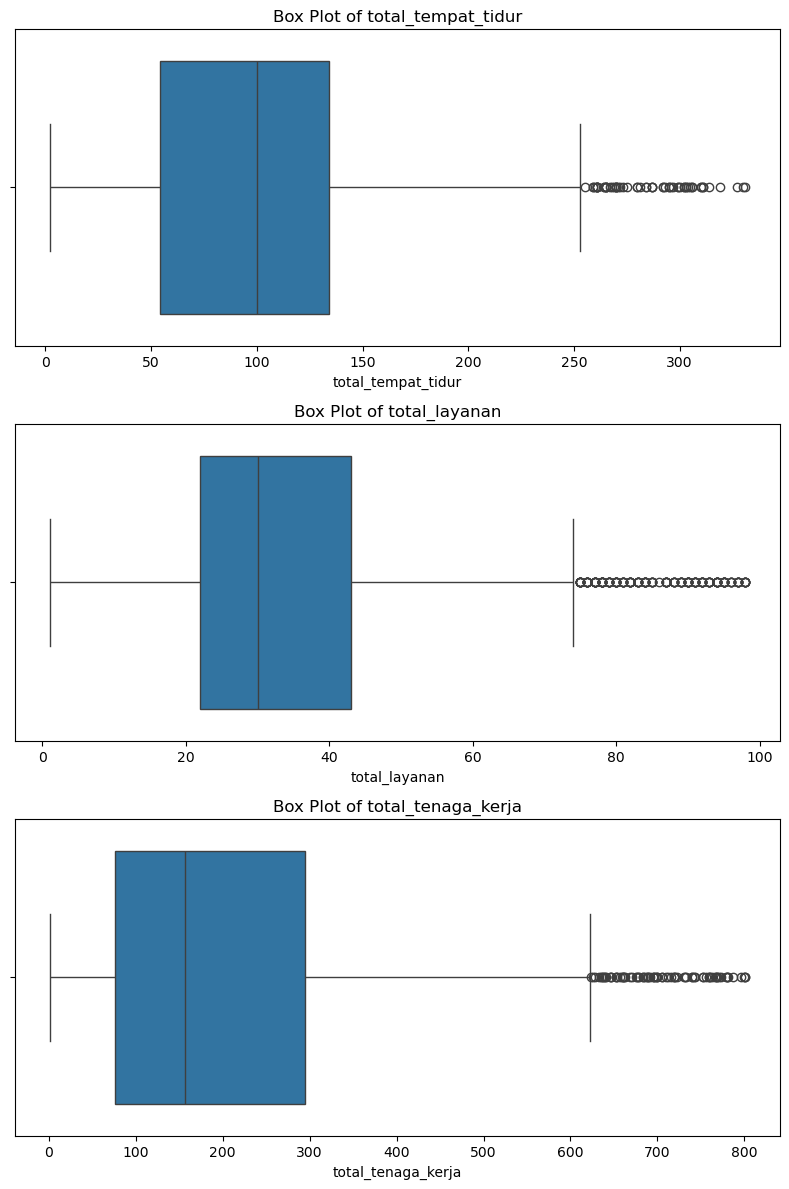

In [30]:
col_fig = 1
row_fig = 3
col_numeric = ['total_tempat_tidur', 'total_layanan', 'total_tenaga_kerja']

plt.figure(figsize=(8, 12))
for i, col in enumerate(col_numeric, 1):
    plt.subplot(row_fig,col_fig,i)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

**Insight:**

- Untuk `total_tempat_tidur`, boxplot menunjukkan distribusi yang lebih terkosentrasi. Nilai ekstrem yang sebelumnya berada di atas 10.000 tempat tidur telah berhasil dihilangkan. Kini sebagian besar rumah sakit memiliki tempat tidur dalam rentang 0-300 yang lebih realistis.

- Untuk `total_layanan`, outlier ekstrim di atas 400 layanan telah dihapus. Distribusi sekarang menunjukkan rumah sakit umumnya memiliki 10–70 jenis layanan.

- Untuk `total_tenaga_kerja`, boxplot jauh lebih stabil, dengan outlier di atas 8000 tenaga kerja berhasil dibuang. Mayoritas rumah sakit kini berada dalam kisaran 0–600 tenaga kerja, menjadikan data lebih seimbang dan mudah dianalisis.

In [31]:
df.describe()

,total_tempat_tidur,total_layanan,total_tenaga_kerja
count,2457.000000,2457.000000,2457.000000
mean,104.891331,35.318681,207.982092
std,61.634370,19.474316,170.397976
min,2.000000,1.000000,1.000000
25%,54.000000,22.000000,76.000000
50%,100.000000,30.000000,157.000000
75%,134.000000,43.000000,295.000000
max,331.000000,98.000000,801.000000


**Insight:**

- Distribusi data lebih wajar dan stabil setelah pembersihan, sehingga cocok untuk pemodelan dan interpretasi.

- Median mendekati rata-rata untuk semua fitur, menandakan distribusi data mulai menyerupai normal (simetris).

- Nilai maksimum yang kini tidak ekstrem menunjukkan pembersihan outlier berjalan efektif dan data lebih representatif terhadap populasi rumah sakit secara umum.

**Transformasi Data**

Pada tahap ini dilakukan transformasi terhadap kolom numerik untuk mengatasi distribusi data yang miring ke kanan (right-skewed). Hal ini penting agar data memenuhi asumsi distribusi normal yang dibutuhkan oleh sebagian besar algoritma machine learning.

Akan dicek skewness dari fitur numerik menggunakan `skew()`. Kolom dengan skewness > 1 atau < -1 dianggap sangat miring dan perlu ditransformasikan.

In [32]:
# menghitung skewness
df[col_numeric].skew()

total_tempat_tidur    0.911883
total_layanan         1.269068
total_tenaga_kerja    1.200082
dtype: float64

**Insight:** 

Data terlihat sangat skew ke kanan terutama `total_layanan` dan `total_tenaga_kerja`, maka untuk kolom numerik ditransformasikan menggunakan log (terutama untuk skewness > 1).

Dilakukan pemisahan antar data yang ditransformasikan atau tidak untuk kebutuhan masing-masing model nantinya. Data yang ditransformasikan digunakan untuk model sensitif seperti Logisctic Regression.

In [33]:
df_transform = df.copy()

In [34]:
# melakukan transformasi log pada kolom numerik
for col in col_numeric[1:]:
    df_transform[col] = np.log1p(df_transform[col])

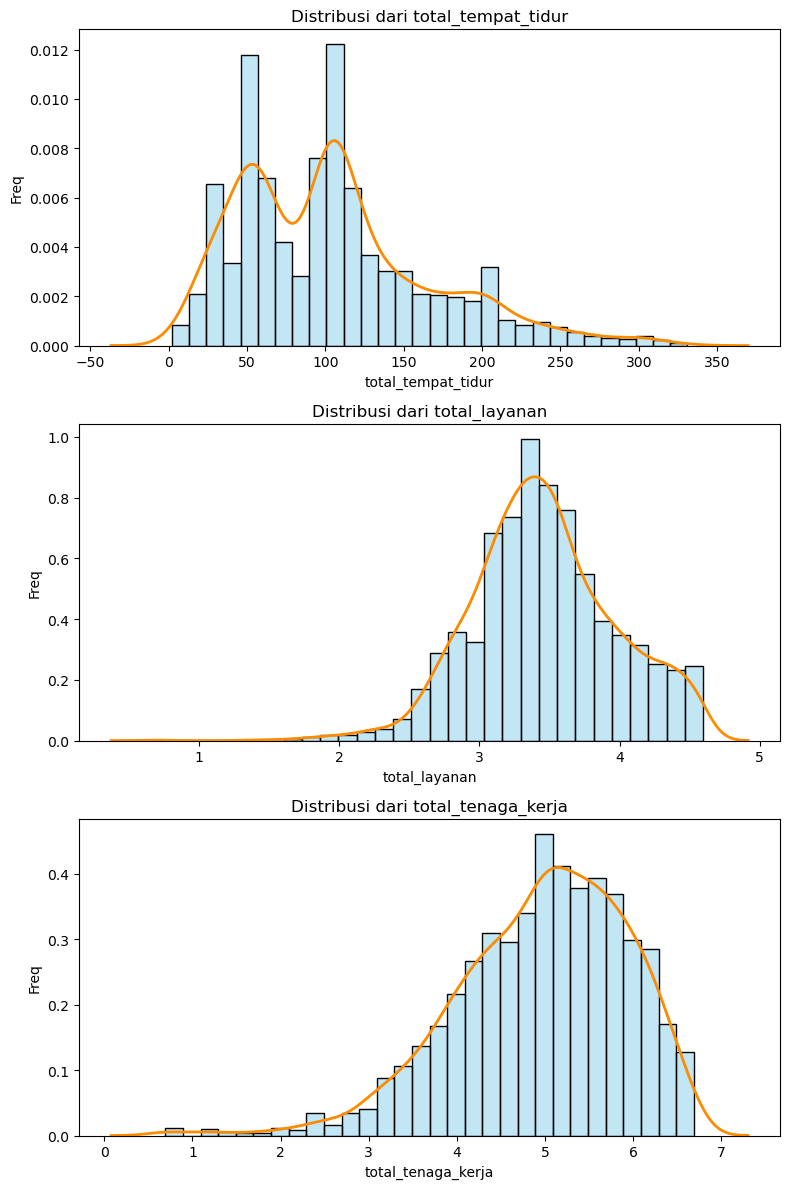

In [35]:
# melihat distribusi
plt.figure(figsize=(8, 12))
for i, col in enumerate(col_numeric, 1):
    plt.subplot(row_fig,col_fig,i)
    sns.histplot(df_transform[col], kde=True, color='skyblue', bins=30, stat='density')
    sns.kdeplot(df_transform[col], color='darkorange', linewidth=2)
    plt.xlabel(col)
    plt.ylabel('Freq')
    plt.title(f'Distribusi dari {col}')
plt.tight_layout()
plt.show()

In [36]:
df_transform[col_numeric].skew()

total_tempat_tidur    0.911883
total_layanan        -0.042044
total_tenaga_kerja   -0.776092
dtype: float64

**Insight:**

- Untuk `total_tempat_tidur` tidak dilakukan transformasi, namun masih tetap digunakan dalam model.

- Untuk `total_layanan` dilakukan transformasi dan skewness berubah menjadi -0.04 yang menunjukkan distribusi hampir simetris. Visualisasi juga mendukung distribusinya menyerupai distribusi normal. 

- Untuk `total_tenaga_kerja` telah dilakukan transformasi dan skewness menjadi -0.77 yang artinya lebih seimbang meskipun sedikit miring ke kiri. Distribusi hasil transformasi tampak lebih smooth dan stabil.

### **4.4. Encoding Kolom Kategorikal**

Pada tahap ini akan dilakukan:

- Seluruh variabel kategorikal seperti `bagian`, `jenis`, `status_blu`, dan `kepemilikan` diubah menjadi format numerik menggunakan One-Hot Encoding. Pemilihan encoding ini dikarenakan tidak memiliki hubungan hierarki antar nilai.
- Variabel target kelas juga diubah menjadi angka dengan Label Encoding untuk model Random Forest.
- Digunakan parameter `drop_first=True` untuk menghindari dummy variable trap.
- Label target (`kelas`) juga diencode menjadi nilai numerik menggunakan `LabelEncoder` agar sesuai dengan model klasifikasi.

In [37]:
df

,jenis,kelas,status_blu,kepemilikan,total_tempat_tidur,total_layanan,total_tenaga_kerja,bagian
0,Rumah Sakit Umum,C,Non BLU/BLUD,Swasta,218.0,36,328.0,Sumatera
1,Rumah Sakit Umum,D,Non BLU/BLUD,Swasta,45.0,15,45.0,Sumatera
2,Rumah Sakit Umum,B,BLUD,Pemerintah Daerah,310.0,77,487.0,Sumatera
4,Rumah Sakit Umum,C,BLUD,Pemerintah Daerah,189.0,34,537.0,Sumatera
6,Rumah Sakit Umum,D,Non BLU/BLUD,Swasta,102.0,64,208.0,Sumatera
...,...,...,...,...,...,...,...,...
3147,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Daerah,104.0,24,261.0,Indonesia Timur
3148,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Daerah,102.0,23,112.0,Indonesia Timur
3149,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Daerah,86.0,19,164.0,Indonesia Timur
3151,Rumah Sakit Umum,D,Non BLU/BLUD,Pemerintah Daerah,85.0,23,47.0,Indonesia Timur


In [38]:
col_categorical = ['bagian', 'jenis', 'status_blu', 'kepemilikan']

In [39]:
# melakukan encode pada fitur target dengan LabelEncoder
y = LabelEncoder().fit_transform(df['kelas'])


In [40]:
# melakukan encode pada fitur kolom kategorikal dengan One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=col_categorical, drop_first=True)
df_transform_encoded = pd.get_dummies(df_transform, columns=col_categorical, drop_first=True)

In [41]:
# menambahkan fitur target ke DataFrame
df_encoded['kelas'] = y
df_transform_encoded['kelas'] = y

In [42]:
# menampilkan Dataframe setelah encoding
df_encoded

,kelas,total_tempat_tidur,total_layanan,total_tenaga_kerja,bagian_Jawa,bagian_Kalimantan,bagian_Sumatera,jenis_Rumah Sakit Umum,status_blu_BLUD,status_blu_Non BLU/BLUD,kepemilikan_Organisasi Keagamaan,kepemilikan_Organisasi Sosial,kepemilikan_Pemerintah Daerah,kepemilikan_Pemerintah Pusat,kepemilikan_Swasta
0,2,218.0,36,328.0,False,False,True,True,False,True,False,False,False,False,True
1,3,45.0,15,45.0,False,False,True,True,False,True,False,False,False,False,True
2,1,310.0,77,487.0,False,False,True,True,True,False,False,False,True,False,False
4,2,189.0,34,537.0,False,False,True,True,True,False,False,False,True,False,False
6,3,102.0,64,208.0,False,False,True,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,3,104.0,24,261.0,False,False,False,True,False,True,False,False,True,False,False
3148,3,102.0,23,112.0,False,False,False,True,False,True,False,False,True,False,False
3149,3,86.0,19,164.0,False,False,False,True,False,True,False,False,True,False,False
3151,3,85.0,23,47.0,False,False,False,True,False,True,False,False,True,False,False


In [43]:
# menampilkan Dataframe setelah encoding
df_transform_encoded

,kelas,total_tempat_tidur,total_layanan,total_tenaga_kerja,bagian_Jawa,bagian_Kalimantan,bagian_Sumatera,jenis_Rumah Sakit Umum,status_blu_BLUD,status_blu_Non BLU/BLUD,kepemilikan_Organisasi Keagamaan,kepemilikan_Organisasi Sosial,kepemilikan_Pemerintah Daerah,kepemilikan_Pemerintah Pusat,kepemilikan_Swasta
0,2,218.0,3.610918,5.796058,False,False,True,True,False,True,False,False,False,False,True
1,3,45.0,2.772589,3.828641,False,False,True,True,False,True,False,False,False,False,True
2,1,310.0,4.356709,6.190315,False,False,True,True,True,False,False,False,True,False,False
4,2,189.0,3.555348,6.287859,False,False,True,True,True,False,False,False,True,False,False
6,3,102.0,4.174387,5.342334,False,False,True,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,3,104.0,3.218876,5.568345,False,False,False,True,False,True,False,False,True,False,False
3148,3,102.0,3.178054,4.727388,False,False,False,True,False,True,False,False,True,False,False
3149,3,86.0,2.995732,5.105945,False,False,False,True,False,True,False,False,True,False,False
3151,3,85.0,3.178054,3.871201,False,False,False,True,False,True,False,False,True,False,False


### **4.5. Feature scaling**

Pada tahap ini akan dilakukan:

- Scaling hanya dilakukan untuk model yang memerlukannya, yaitu Logistic Regression. Scaling dilakukan dengan `StandardScaler()`
- Dilakukan standarisasi untuk kolom numerik, yaitu `total_tempat_tidur`, `total_layanan`, dan `total_tenaga_kerja` karena akan digunakan pada model Logistic Regression.

In [44]:
scaler = StandardScaler()
df_transform_encoded[col_numeric] = scaler.fit_transform(df_transform_encoded[col_numeric])
df_transform_encoded

,kelas,total_tempat_tidur,total_layanan,total_tenaga_kerja,bagian_Jawa,bagian_Kalimantan,bagian_Sumatera,jenis_Rumah Sakit Umum,status_blu_BLUD,status_blu_Non BLU/BLUD,kepemilikan_Organisasi Keagamaan,kepemilikan_Organisasi Sosial,kepemilikan_Pemerintah Daerah,kepemilikan_Pemerintah Pusat,kepemilikan_Swasta
0,2,1.835529,0.291027,0.855724,False,False,True,True,False,True,False,False,False,False,True
1,3,-0.971917,-1.347077,-1.150781,False,False,True,True,False,True,False,False,False,False,True
2,1,3.328507,1.748309,1.257815,False,False,True,True,True,False,False,False,True,False,False
4,2,1.364917,0.182443,1.357296,False,False,True,True,True,False,False,False,True,False,False
6,3,-0.046921,1.392051,0.392986,False,False,True,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,3,-0.014465,-0.475027,0.623486,False,False,False,True,False,True,False,False,True,False,False
3148,3,-0.046921,-0.554794,-0.234179,False,False,False,True,False,True,False,False,True,False,False
3149,3,-0.306569,-0.911052,0.151900,False,False,False,True,False,True,False,False,True,False,False
3151,3,-0.322797,-0.554794,-1.107376,False,False,False,True,False,True,False,False,True,False,False


### **4.6. Split dataset**

Pada tahap ini akan dilakukan:

- Data dibagi menjadi training dan testing set dengan perbandingan 80:20 menggunakan `train_test_split`.
- Parameter `stratify=y` digunakan untuk menjaga distribusi kelas tetap proporsional pada data pelatihan dan pengujian.
- Pembagian dilakukan dua kali: satu untuk dataset transformasi log, satu untuk data tanpa transformasi (untuk perbandingan antar model).

In [45]:
X = df_encoded.drop(columns=['kelas'])
X_transform = df_transform_encoded.drop(columns=['kelas'])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [47]:
X_train_transform, X_test_transfrom, y_train_transform, y_test_transform = train_test_split(
    X_transform, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [48]:
smotetomek = SMOTETomek(random_state=42)

X_train_resampled_smotetomek, y_train_resampled_smotetomek = smotetomek.fit_resample(X_train, y_train)

print("Distribusi kelas sebelum oversampling:", Counter(y_train))
print("Distribusi kelas setelah oversampling:", Counter(y_train_resampled_smotetomek))

Distribusi kelas sebelum oversampling: Counter({2: 1201, 3: 581, 1: 162, 0: 21})
Distribusi kelas setelah oversampling: Counter({1: 1168, 0: 1166, 3: 1144, 2: 1108})


Dataset telah dibagi secara proporsional dan adil terutama setelah dilakukan resampling sehingga sudah siap digunakan untuk pelatihan model klasifikasi. Metode resampling ini memungkinkan evaluasi performa dan robustnes model terhadap tidak keseimbangan data.

## **5. Modelling**

Algoritma yang digunakan adalah Logistic Regression (multiclass) dan Random Forest. Untuk Logistic Regression akan menggunakan data yang telah ditransformasi pada tahap **Data Preparation**, sedangkan untuk Random Forest diterapkan pada data tanpa transformasi. Kedua model dilatih untuk memprediksi kelas rumah sakit berdasarkan fitur-fitur numerik (jumlah tempat tidur, layanan, dan tenaga kerja) serta fitur kategorikal (jenis, status BLU, kepemilikan, dan wilayah).

### **5.1. Random Forest**

 Skema 1: Baseline

Model ini dilatih dengan data training tanpa tekhnik resampling. Karena ketidakseimbangan data tiap kelas, maka diperlukan `class_weight='balanced'` untuk menyesuaikan bobot.

In [49]:
rf_scheme_1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

rf_scheme_1.fit(X_train, y_train)
y_pred_rf_1 = rf_scheme_1.predict(X_test)

Skema 2: Resampling

Model ini dilatih menggunakan data training yang telah diolah dengan teknik SMOTETomek untuk mengatasi ketidakseimbangan data. Model ini akan dibandingkan performanya dengan skema baseline untuk menilai sejauh mana teknik resampling dapat memperbaiki ketimpangan prediksi antar kelas.

In [50]:
rf_scheme_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

rf_scheme_2.fit(X_train_resampled_smotetomek, y_train_resampled_smotetomek)
y_pred_rf_2 = rf_scheme_2.predict(X_test)

Skema 3: Resampling + Tuning Hyperparameter

Model ini merupakan pengembangan dari skema 2 dengan menambahkan proses hyperparamater tuning. Tujuannya adlah untuk menemukan kombinasi parameter terbaik yang dapat meningkatkan generalisasi dan akurasi model, terutama terhadap kelas minoritas. Pada tahap ini dilakukan Grid Search dan Random Search.

In [51]:
# parameter yang diuji dengan Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', {0:1, 1:3, 2:1, 3:1.5}]
}

# parameter yang diuji dengan Random Search
param_random = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'class_weight': ['balanced', None]
}


In [52]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_resampled_smotetomek, y_train_resampled_smotetomek)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced',
                                          {0: 1, 1: 3, 2: 1, 3: 1.5}],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro', verbose=2)

**Insight:**

Dengan metode Grid Search, diperoleh parameter terbaiknya adalah:
- `class_weight='balanced'`
- `max_depth=20`
- `min_samples_split=5`
- `n_estimators=300`
- `random_state=42`

In [53]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_random,
    scoring='f1_macro',
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_resampled_smotetomek, y_train_resampled_smotetomek)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [None, 5, 10, 15, 20, 25,
                                                      30],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AC6A4BD820>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AC66429880>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AC660C9010>},
                   random_state=42, scoring='f1_macro', verbose=2)

**Insight:**

Dengan metode Random Search, diperoleh parameter terbaiknya adalah:
- `class_weight='balanced'`
- `max_depth=35`
- `min_samples_split=3`
- `n_estimators187`
- `random_state=42`

In [54]:
# menyimpan model dengan parameter terbaik
model_grid = grid_search.best_estimator_
model_random = random_search.best_estimator_

# Prediksi menggunakan data test
y_pred_grid = model_grid.predict(X_test)
y_pred_random = model_random.predict(X_test)

### **5.2. Logistic Regression**

Skema 1: Baseline

Pada skema ini digunakan algoritma Logistic Regression multikelas sebagai baseline untuk klasifikasi kelas rumah sakit. Model dilatih menggunakan data yang telah ditransformasi (menggunakan log untuk kolom numerik), yang sebelumnya disiapkan pada tahap **Data Preparation**.

In [55]:
lr_scheme_1 = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_scheme_1.fit(X_train_transform, y_train_transform)
y_pred_lr_scheme_1 = lr_scheme_1.predict(X_test_transfrom)

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Skema 2: Resampling + Polynomial Features

Skema ini mengembangkan baseline Logistic Regression dengan dua pendekatan tambahan:

- Ekspansi fitur menggunakan Polynomial Features.

- Penyeimbangan data dengan SMOTETomek.

Pendekatan ini bertujuan untuk meningkatkan kapasitas model Logistic Regression dalam menangkap interaksi antar fitur serta mengatasi masalah class imbalance.

In [56]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_transform)
X_test_poly = poly.transform(X_test_transfrom)

X_res_poly, y_res_poly = smotetomek.fit_resample(X_poly, y)

In [57]:
lr_scheme_2 = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    C=0.1,
    random_state=42
)
lr_scheme_2.fit(X_res_poly, y_res_poly)

y_pred_lr_scheme_2 = lr_scheme_2.predict(X_test_poly)


c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## **6. Evaluation**

### **6.1. Random Forest**

Skema 1

Pada tahap ini dilakukan evaluasi terhadap model Random Forest yang dilatih menggunakan skema baseline tanpa resampling. Evaluasi dilakukan menggunakan tiga metrik utama: akurasi, classification report, dan confusion matrix.

Accuracy: 0.8861788617886179
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.70      0.39      0.50        41
           2       0.87      0.95      0.91       301
           3       0.94      0.90      0.92       145

    accuracy                           0.89       492
   macro avg       0.88      0.76      0.80       492
weighted avg       0.88      0.89      0.88       492



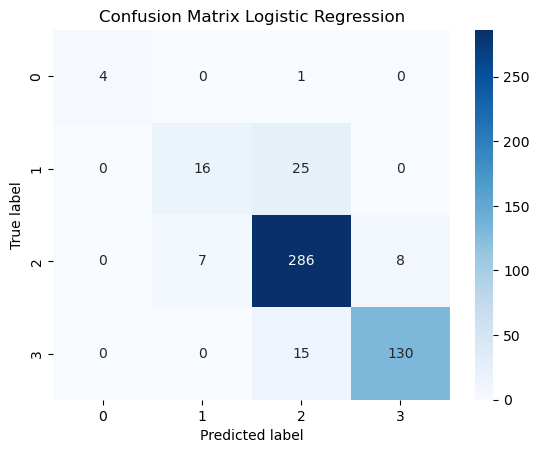

In [58]:
# Evaluasi akurasi
print("Accuracy:", accuracy_score(y_test, y_pred_rf_1))

# Classification Report
print(classification_report(y_test, y_pred_rf_1))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf_1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

**Insight:**

- Akurasi keseluruhan mencapai 88.6% yang menunjukkan performa cukup baik secara umum.
- Kelas mayoritas (2 dan 3) memiliki F1-Score tinggi (> 0.90), menunjukkanmodel sangat baik memprediksi kelas dominan.
- Kelas minoritas (0 dan 1) memiliki performa lebih rendah, terutama recall kelas 1 hanya 0.39, menandakan model sering gagal mengenali kelas tersebut.
- Hal ini menegaskan pentingnya pendekatan resampling atau penyesuaian lebih lanjut seperti tuning atau rebalancing agar performa terhadap kelas minoritas meningkat.

Skema 2

Model pada skema ini menggunakan data training hasil SMOTETomek, yaitu kombinasi teknik oversampling dan undersampling untuk menangani ketidakseimbangan kelas. Tujuan utamanya adalah meningkatkan kemampuan model dalam memprediksi kelas minoritas.

Accuracy: 0.8861788617886179
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.59      0.63      0.61        41
           2       0.92      0.90      0.91       301
           3       0.94      0.92      0.93       145

    accuracy                           0.89       492
   macro avg       0.74      0.86      0.78       492
weighted avg       0.89      0.89      0.89       492



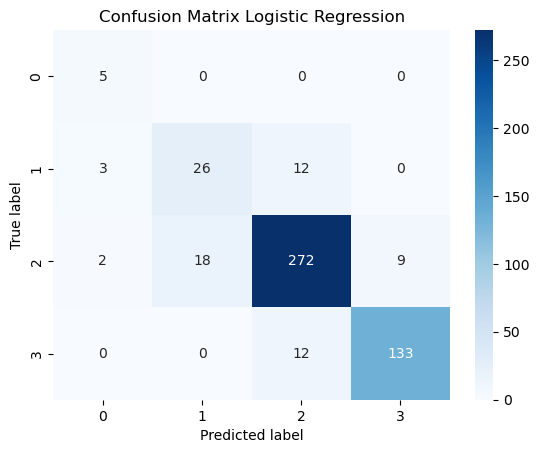

In [59]:
# Evaluasi akurasi
print("Accuracy:", accuracy_score(y_test, y_pred_rf_2))

# Classification Report
print(classification_report(y_test, y_pred_rf_2))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

**Insight:** 

- Akurasi model tetap stabil di 88.6% seperti baseline.
- Kelas 0 (minoritas) mengalami peningkatan recall dari 0.80 menjadi 1.00, artinya semua data kelas 0 di test set berhasil diprediksi dengan benar.
- Kelas 1 juga meningkat dari recall 0.39 menjadi 0.61 dan f1-score dari 0.50 menjadi 0.60.
- Kelas mayoritas (2 dan 3) tetap memiliki performa tinggi dan stabil.
- Dari Confusion Marix, peningkaan jumlah prediksi benar di kelas minoritas. Selain itu, terjadi penurunan jumlah kesalahan klasifikasi terutama pada kelas 1 yang sebelumnya paling sulit diprediksi.
- Resampling dengan SMOTETomek berhasil meningkatkan performa model terhadap kelas minoritas tanpa mengorbankan akurasi secara keseluruhan.

Skema 3

Pada skema ini, model Random Forest dilatih menggunakan data yang telah diseimbangkan dengan SMOTETomek, lalu dilakukan pencarian kombinasi hyperparameter terbaik menggunakan dua pendekatan:

- GridSearchCV, yaitu pencarian menyeluruh pada kombinasi parameter yang ditentukan.

- RandomizedSearchCV, yaitu pencarian acak pada ruang parameter yang lebih luas dan efisien.



=== GridSearchCV Evaluation ===
Accuracy: 0.8963414634146342
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.63      0.66      0.64        41
           2       0.92      0.92      0.92       301
           3       0.95      0.92      0.93       145

    accuracy                           0.90       492
   macro avg       0.75      0.87      0.79       492
weighted avg       0.90      0.90      0.90       492



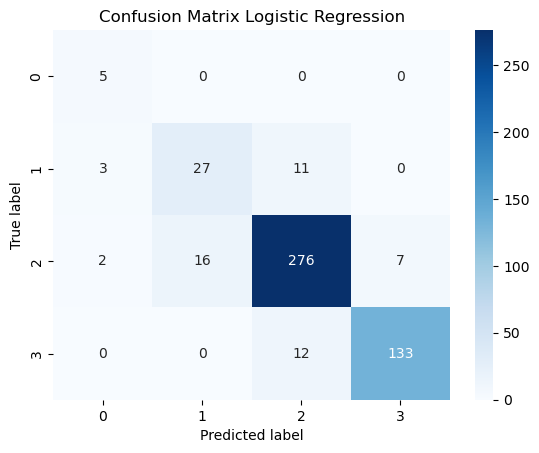

In [60]:
print("=== GridSearchCV Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_grid))
print("Classification Report:\n", classification_report(y_test, y_pred_grid))

cm = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Logistic Regression')
plt.show()


**Insight:** 

- Akurasi model meningkat menjadi 89.6%, tertinggi di antara semua skema.
- Kelas 0 (sangat minoritas) diprediksi 100% benar (recall = 1.00), meskipun precision masih 0.50 karena jumlah sampelnya kecil.
- Kelas 1 mengalami peningkatan F1-score menjadi 0.64, jauh lebih baik dibanding baseline (0.50).
- Kelas mayoritas (2 dan 3) tetap menunjukkan performa tinggi dan stabil.
- Berdasarkan Confusion Matrix:
    - Distribusi prediksi jauh lebih merata.
    - Kelas 1 lebih banyak yang terklasifikasi benar dibanding skema sebelumnya.
    - Kelas 3 hanya sedikit prediksi yang meleset ke kelas 2.

=== RandomizedSearchCV Evaluation ===
Accuracy: 0.8902439024390244
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.61      0.66      0.64        41
           2       0.92      0.91      0.91       301
           3       0.94      0.92      0.93       145

    accuracy                           0.89       492
   macro avg       0.74      0.87      0.79       492
weighted avg       0.90      0.89      0.89       492



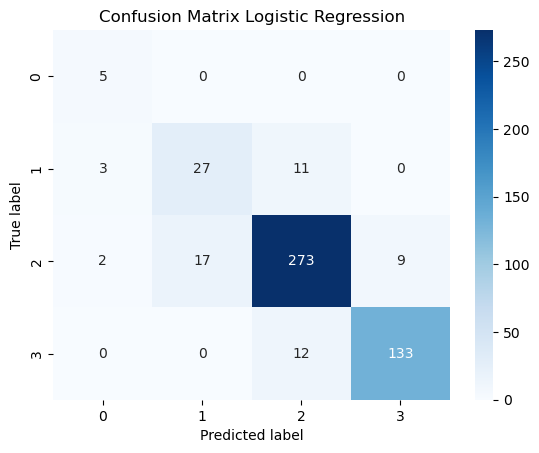

In [61]:
print("=== RandomizedSearchCV Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_random))
print("Classification Report:\n", classification_report(y_test, y_pred_random))

cm = confusion_matrix(y_test, y_pred_random)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

**Insight:** 

- Cukup tinggi dan hampir menyamai hasil GridSearchCV (89.6%).
- Kelas 0: Recall sempurna (1.00), meski precision 0.50 karena jumlahnya sangat kecil.
- Kelas 1: F1-score = 0.64, hampir sama dengan GridSearchCV → menunjukkan performa konsisten untuk kelas minoritas.
- Kelas mayoritas (2 dan 3) tetap menunjukkan performansi yang sangat baik dan stabil.
- Hanya terjadi perbedaan kecil pada prediksi kelas 2 dan 3, menunjukkan RandomizedSearchCV memberikan hasil kompetitif dengan waktu pencarian yang lebih singkat.

**Ringkasan:**
- RandomizedSearchCV memberikan hasil hampir setara dengan GridSearchCV, baik dari segi akurasi maupun distribusi prediksi antar kelas.
- Merupakan alternatif lebih efisien secara waktu komputasi, terutama jika parameter grid besar.
- Model menunjukkan generalisasi yang sangat baik, bahkan untuk kelas minoritas yang sebelumnya bermasalah.

### **6.2. Logistic Regression**

Skema 1

Pada skema ini, dilakukan evaluasi terhadap model Logistic Regression multikelas yang dilatih menggunakan data transformasi log, tanpa teknik penyeimbangan data (resampling) maupun rekayasa fitur tambahan.

Accuracy: 0.806910569105691
              precision    recall  f1-score   support

           0       0.22      1.00      0.36         5
           1       0.46      0.63      0.53        41
           2       0.92      0.78      0.84       301
           3       0.84      0.91      0.87       145

    accuracy                           0.81       492
   macro avg       0.61      0.83      0.65       492
weighted avg       0.85      0.81      0.82       492



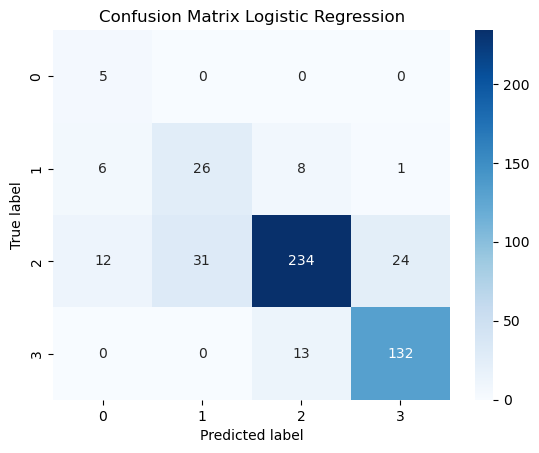

In [62]:
# Evaluasi akurasi
print("Accuracy:", accuracy_score(y_test, y_pred_lr_scheme_1))

# Classification Report
print(classification_report(y_test, y_pred_lr_scheme_1))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr_scheme_1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

**Insight:** 
- Akurasi sebesar 0.8069 atau sekitar 80.7%, cukup baik namun lebih rendah dibanding skema Random Forest.
- Kelas 0: Terprediksi semua benar (recall 1.00), namun precision sangat rendah (0.22), artinya banyak false positives untuk kelas ini.
- Kelas 1: Recall dan F1-score rendah (0.53 dan 0.58), menunjukkan model kesulitan membedakan kelas ini.
- Kelas mayoritas (2 dan 3): Tetap solid, tapi recall kelas 2 turun ke 0.78 dari >0.90 pada model Random Forest.
- Dari Confusion Matrix:
    - Banyak kesalahan klasifikasi pada kelas 2 → terlihat dari banyaknya prediksi yang salah ke kelas 1 dan 3.
    - Model lebih sering mengaburkan batas antar kelas yang mirip, terutama 1 vs 2.



Skema 2

Pada skema ini, model Logistic Regression multikelas dilatih menggunakan:
- Data yang telah ditransformasi log.
- Ekspansi fitur polinomial derajat 2 dengan `interaction_only=True` untuk menangkap interaksi antar fitur.
- SMOTETomek untuk menyeimbangkan distribusi kelas sebelum pelatihan.

Pendekatan ini bertujuan untuk memperkuat kapasitas model dalam mendeteksi pola antar fitur dan memperbaiki prediksi terhadap kelas minoritas.



Accuracy: 0.8800813008130082
Classification Report:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       0.64      0.85      0.73        41
           2       0.93      0.87      0.90       301
           3       0.90      0.90      0.90       145

    accuracy                           0.88       492
   macro avg       0.73      0.91      0.79       492
weighted avg       0.89      0.88      0.88       492



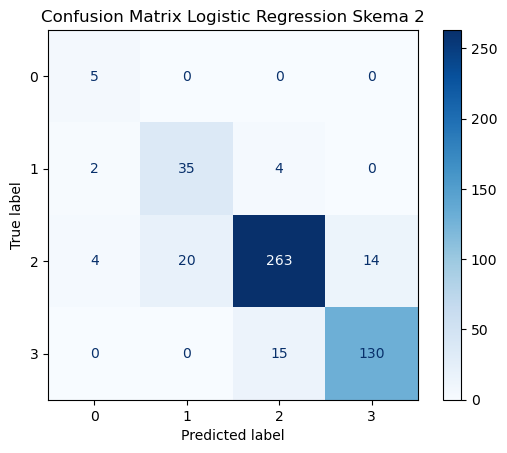

In [63]:
print("Accuracy:", accuracy_score(y_test_transform, y_pred_lr_scheme_2))
print("Classification Report:\n", classification_report(y_test_transform, y_pred_lr_scheme_2))

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test_transform, y_pred_lr_scheme_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Logistic Regression Skema 2")
plt.show()

**Insight:**

- Mengalami peningkatan signifikan dari baseline (80.7%) ke skema 2.
- Kelas 0 (minoritas): Recall sempurna (1.00), meskipun precision masih rendah (0.45).
- Kelas 1: F1-score naik drastis ke 0.73 dari 0.58 di baseline.
- Kelas mayoritas (2 dan 3) tetap memiliki f1-score stabil di atas 0.90.
- Dari Confusion Matrix:
    - Kelas minoritas (0 & 1) jauh lebih terprediksi akurat.
    - Kesalahan antar kelas lebih terdistribusi merata, dengan penurunan false positive signifikan untuk kelas 1 dan 2.
    - Kelas mayoritas tetap memiliki prediksi dominan yang kuat.
- Resampling + Polynomial Features terbukti efektif meningkatkan kinerja Logistic Regression.

### **6.3. Kesimpulan**

- Resampling sangat penting untuk meningkatkan kinerja model terhadap kelas minoritas.
- GridSearchCV menghasilkan model dengan akurasi dan f1-score tertinggi, meskipun memerlukan waktu komputasi lebih besar.
- Logistic Regression + Polynomial + SMOTETomek menjadi alternatif yang lebih ringan dan cukup kompetitif, cocok jika interpretabilitas model dibutuhkan.
- Model baseline tanpa penanganan imbalance sangat bias terhadap kelas mayoritas, terbukti dari rendahnya f1-score kelas 1 dan 0.